## data

full_dataset feature : Province/state, country/region, lat, long, date, confirmed, death, recovered 

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=97a924852d43447898f770f90da13cbfe82ac3e3eff83438f7d40e173c014b8c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import requests
import pandas as pd
import wget

In [0]:
# data file url (실시간 데이터)
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

# 파일 다운
for url in urls:
    filename = wget.download(url)

In [0]:
# data
conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [119]:
conf_df.head() # 확인 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86


In [120]:
deaths_df.head() # 확인 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43,47,50,57,58,60,64,68,72,85,90,95,104,106,109,115,120,122,127,132,136,153,168,169,173,178,187,193,205,216,218,219,220,227,235,246,249,257,265,270
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,27,27,28,28,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,33,33,33,33,33,33,33,33
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,415,419,425,432,437,444,450,453,459,463,465,470,476,483,488,494,502,507,515,522,529,536,542,548,555,561,568,575,582,592,600,609,617,623,630,638,646,653,661,667
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,40,40,40,40,41,42,42,43,44,45,45,46,46,47,47,48,48,48,48,49,49,49,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4


In [0]:
# 데이터에서 Date만 따로 추출
dates = conf_df.columns[4:]

In [88]:
conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Recovered')

recv_df_long = recv_df_long[recv_df_long['Country/Region']!='Canada']

print(conf_df_long.shape)
print(deaths_df_long.shape)
print(recv_df_long.shape)

(35378, 6)
(35378, 6)
(33516, 6)


In [89]:
#merge
full_table = pd.merge(left=conf_df_long, right=deaths_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])
full_table = pd.merge(left=full_table, right=recv_df_long, how='left',
                      on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'])

full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0.0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0.0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0.0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0.0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0.0


In [90]:
full_table.shape # matrix shape check

(35378, 8)

In [91]:
full_table.isna().sum() # 결측치 확인 

Province/State    24605
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered          3724
dtype: int64

In [92]:
full_table['Province/State'].value_counts()

Zhejiang                        133
St Martin                       133
Anguilla                        133
Gibraltar                       133
Liaoning                        133
                               ... 
Shanxi                          133
Australian Capital Territory    133
Montserrat                      133
Tasmania                        133
Queensland                      133
Name: Province/State, Length: 81, dtype: int64

In [0]:
# Province/State nan값 대체 
# delete col?
## 구글맵 불러와서?

In [94]:
# Recovered nan값은 평균대체 -> min, max의 차이 많이남 
full_table['Recovered'].fillna(full_table['Recovered'].mean())

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
            ...     
35373      68.000000
35374    2430.302711
35375      27.000000
35376    2430.302711
35377       1.000000
Name: Recovered, Length: 35378, dtype: float64

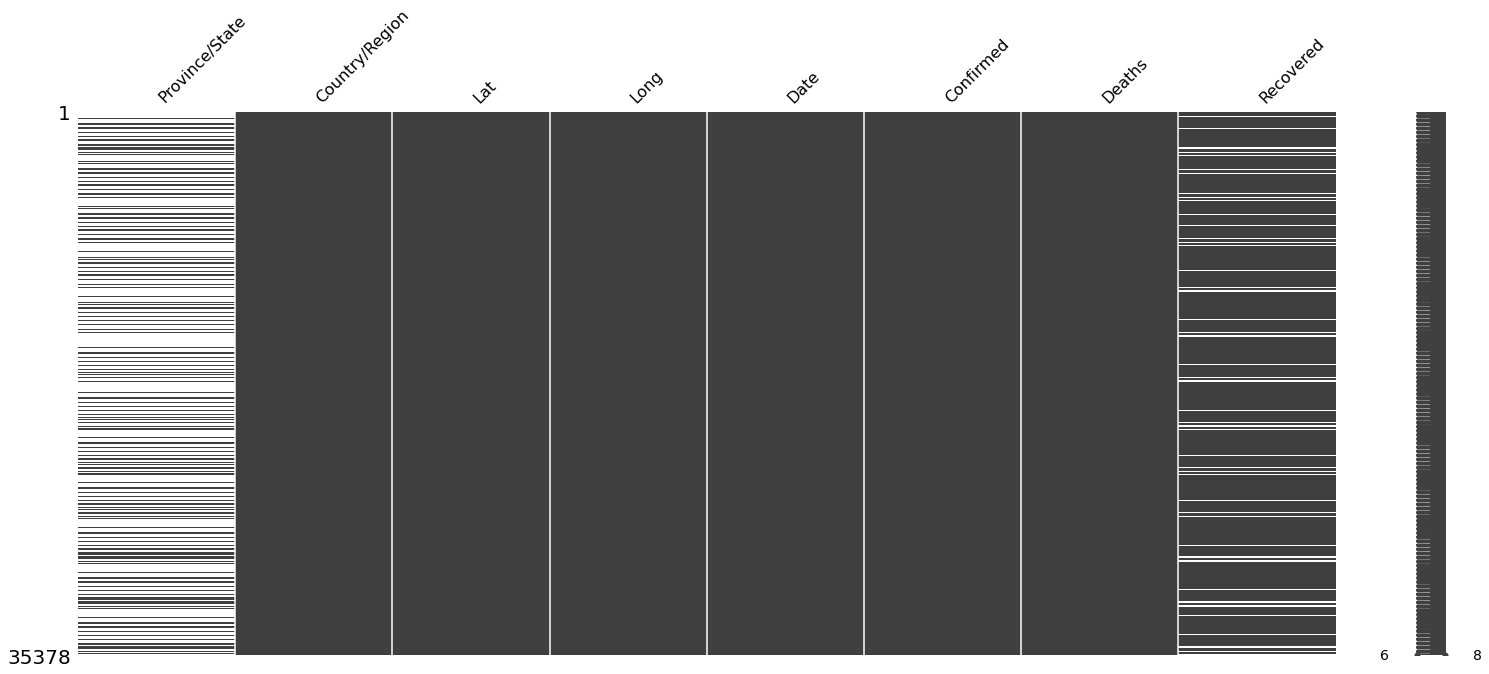

In [95]:
# 결측치 시각화 -> 패턴? 없다? 
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(full_table) 

In [0]:
df = full_table[['Confirmed','Deaths', 'Recovered']]

In [0]:
df2 = full_table[['Province/State', 'Country/Region', 'Lat', 'Long', 'Date']]

In [98]:
# multiple imputation
# original data와 대체법 이후의 data가 동일한 분포를 가지도록 결측치 채움 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

IterativeImputer(verbose = 2).fit_transform(df)

[IterativeImputer] Completing matrix with shape (35378, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 10680.755557429955, scaled tolerance: 1831.8210000000001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.05
[IterativeImputer] Change: 0.0, scaled tolerance: 1831.8210000000001 
[IterativeImputer] Early stopping criterion reached.


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.32000000e+02, 2.00000000e+00, 2.70000000e+01],
       [4.10000000e+03, 4.70000000e+01, 1.64477451e+03],
       [2.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [99]:
list(df.columns)

['Confirmed', 'Deaths', 'Recovered']

In [100]:
# array를 dataframe형식으로 변환
tmp = pd.DataFrame(IterativeImputer(verbose=False).fit_transform(df))
tmp.shape

(35378, 3)

In [0]:
# 대체된 데이터를 다시 full_table에 저장하려고 한다
df_cols = list(df.columns)
tmp.columns = df_cols

In [102]:
full_table = pd.concat([tmp, df2], axis=1)
full_table.head()

,Confirmed,Deaths,Recovered,Province/State,Country/Region,Lat,Long,Date
0,0.0,0.0,0.0,NaN,Afghanistan,33.0000,65.0000,1/22/20
1,0.0,0.0,0.0,NaN,Albania,41.1533,20.1683,1/22/20
2,0.0,0.0,0.0,NaN,Algeria,28.0339,1.6596,1/22/20
3,0.0,0.0,0.0,NaN,Andorra,42.5063,1.5218,1/22/20
4,0.0,0.0,0.0,NaN,Angola,-11.2027,17.8739,1/22/20


In [103]:
full_table.info() # 결측값 없앰을 확인 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35378 entries, 0 to 35377
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Confirmed       35378 non-null  float64
 1   Deaths          35378 non-null  float64
 2   Recovered       35378 non-null  float64
 3   Province/State  10773 non-null  object 
 4   Country/Region  35378 non-null  object 
 5   Lat             35378 non-null  float64
 6   Long            35378 non-null  float64
 7   Date            35378 non-null  object 
dtypes: float64(5), object(3)
memory usage: 2.2+ MB


In [0]:
# 여러개 지역이 있는 경우 제거 
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]

In [0]:
# Province/State에 Recovered string이 포함된 것 제거
full_table = full_table[full_table['Province/State'].str.contains('Recovered')!=True]

In [0]:
# Date col -> year mon day로 각각 col전환(Date col은 drop안함)
full_table['year'] = full_table.Date.str.split('/').str[0]
full_table['month'] = full_table.Date.str.split('/').str[1]
full_table['day'] = full_table.Date.str.split('/').str[2]

In [0]:
full_table.to_csv('full_data.csv', index=False)

In [107]:
full_table.head()

,Confirmed,Deaths,Recovered,Province/State,Country/Region,Lat,Long,Date
0,0.0,0.0,0.0,NaN,Afghanistan,33.0000,65.0000,1/22/20
1,0.0,0.0,0.0,NaN,Albania,41.1533,20.1683,1/22/20
2,0.0,0.0,0.0,NaN,Algeria,28.0339,1.6596,1/22/20
3,0.0,0.0,0.0,NaN,Andorra,42.5063,1.5218,1/22/20
4,0.0,0.0,0.0,NaN,Angola,-11.2027,17.8739,1/22/20


## 새로운 feature생성 
- confirmed --> death or recoveries or active로 구분가능, active 변수 생성
- 잠재변수 생성

In [108]:
# 주어진 데이터 처음과 마지막 날짜 확인 
a = full_table.Date.value_counts().sort_index()
print(a.index[0])
print(a.index[-1])

1/22/20
6/2/20


In [109]:
full_table[full_table['Recovered'].isna()]['Country/Region'].value_counts()

Series([], Name: Country/Region, dtype: int64)

In [0]:
# 새로운 상태 추가 : active
full_table['active'] = full_table['Confirmed']-full_table['Deaths']-full_table['Recovered']

In [111]:
full_table.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Province/State', 'Country/Region',
       'Lat', 'Long', 'Date', 'active'],
      dtype='object')

In [0]:
# 잠재변수 생성 


## full_data 바탕, 장소+시간에 따른 감염 시각화

In [0]:
import plotly.express as px

In [114]:
df = full_table
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y')
df = df.fillna('-')
fig = px.density_mapbox(df, lat='Lat', lon='Long', z='Confirmed', radius=20,zoom=1, hover_data=["Country/Region",'Province/State',"Confirmed"],
                        mapbox_style="carto-positron", animation_frame = 'Date', range_color= [0, 2000],title='Spread of Covid-19')
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

발병 시간과 장소 확인결과, 종결된 지역, 현재 발생하는 지역, 아직 발생하지 않은 지역 등으로 군집분석 후 각 군집에 대해 분석해보는 것도 의미가 있을지도 모르겠다. 